# Explainable AI - Project 1
This project aims to implement a 2D Convolutional Neural Network (CNN) for image classification and then to use two eXplainable AI algorithms to extract the most important areas from the images. After that, a statistical analysis must be performed on the final attributions.


## Imports

In [1]:
from utils import *
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import random

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.auto import tqdm
from torchinfo import summary
from sklearn.model_selection import StratifiedKFold


In [2]:
# Creating lists for dataframe construction
allfiles = os.listdir("dataset")

# Extracting labels from filenames
labels = []
for filename in allfiles:
    # 0 for 'muffin', 1 for 'chihuahua'
    if filename.split(".")[0] == "muffin":
        labels.append(0)
    elif filename.split(".")[0] == "chihuahua":
        labels.append(1)

print("Images count = ",len(allfiles),"\nLabels count = ",len(labels))

# convert all non rgb images to rgb
for filename in allfiles:
    img = Image.open(os.path.join("dataset",filename))
    if img.mode != "RGB":
        img = img.convert("RGB")
        img.save(os.path.join("dataset",filename))

df = pd.DataFrame(columns=["filename","label"])
df["filename"] = allfiles
df["label"] = labels

print("Some items from the dataframe just created:\n",df)

Images count =  5915 
Labels count =  5915
Some items from the dataframe just created:
                 filename  label
0        muffin.3965.jpg      0
1     chihuahua.1088.jpg      1
2      chihuahua.433.jpg      1
3      chihuahua.355.jpg      1
4     chihuahua.1936.jpg      1
...                  ...    ...
5910  chihuahua.1085.jpg      1
5911  chihuahua.4843.jpg      1
5912   chihuahua.358.jpg      1
5913  chihuahua.4857.jpg      1
5914  chihuahua.1091.jpg      1

[5915 rows x 2 columns]


<Axes: xlabel='label', ylabel='count'>

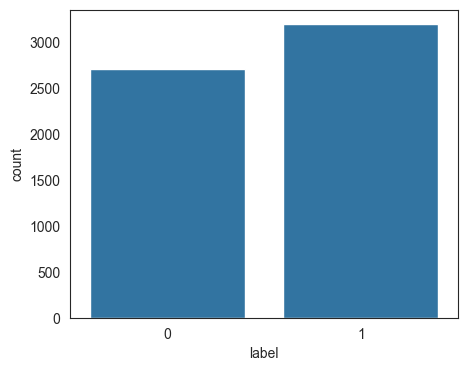

In [3]:
# Barplot to visualize the distribution of the labels 
fig = plt.figure(figsize=(5,4))
sns.set_style("white")
sns.countplot(data=df,x="label")

In [4]:
# Number of splits
n_splits = 5  

# Performing a stratified k-folds subdivision
skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=42)
skf.get_n_splits(df.filename,df.label)

# Storing indices to recover the splits in a second time
train_idx = []
val_idx = []
for i,(train,val) in enumerate(skf.split(df.filename,df.label)):
   train_idx.append(train)
   val_idx.append(val)
   print("Fold: ",i)
   print("\nTrain: index = ",train)
   print("\nValidation:  index = ",val,"\n")

# Check the lengths of all splits
for i in range(5):
    print(f"Length of train_idx[{i}]: {len(train_idx[i])}")
    print(f"Length of val_idx[{i}]: {len(val_idx[i])}")

# If the lengths are not equal, you need to investigate why and fix it.
    
# Storing in csv files    
train_splits = pd.DataFrame(columns=["train_0","train_1","train_2","train_3","train_4"])
val_splits = pd.DataFrame(columns=["val_0","val_1","val_2","val_3","val_4"])
train_splits["train_0"] = train_idx[0]
val_splits["val_0"] = val_idx[0]
train_splits["train_1"] = train_idx[1]
val_splits["val_1"] = val_idx[1]
train_splits["train_2"] = train_idx[2]
val_splits["val_2"] = val_idx[2]
train_splits["train_3"] = train_idx[3]
val_splits["val_3"] = val_idx[3]
train_splits["train_4"] = train_idx[4]
val_splits["val_4"] = val_idx[4]
train_splits.to_csv("csv/train_splits.csv") # save the values in a csv
val_splits.to_csv("csv/val_splits.csv") # save the values in a csv

Fold:  0

Train: index =  [   1    2    3 ... 5912 5913 5914]

Validation:  index =  [   0    5   13 ... 5889 5895 5898] 

Fold:  1

Train: index =  [   0    1    2 ... 5910 5913 5914]

Validation:  index =  [  10   19   22 ... 5909 5911 5912] 

Fold:  2

Train: index =  [   0    2    5 ... 5911 5912 5913]

Validation:  index =  [   1    3    4 ... 5907 5910 5914] 

Fold:  3

Train: index =  [   0    1    3 ... 5911 5912 5914]

Validation:  index =  [   2    7    9 ... 5903 5905 5913] 

Fold:  4

Train: index =  [   0    1    2 ... 5912 5913 5914]

Validation:  index =  [  11   25   29 ... 5874 5877 5887] 

Length of train_idx[0]: 4732
Length of val_idx[0]: 1183
Length of train_idx[1]: 4732
Length of val_idx[1]: 1183
Length of train_idx[2]: 4732
Length of val_idx[2]: 1183
Length of train_idx[3]: 4732
Length of val_idx[3]: 1183
Length of train_idx[4]: 4732
Length of val_idx[4]: 1183


In [5]:
# Recovering train and validation splits
train_idx = pd.read_csv("csv/train_splits.csv")
val_idx = pd.read_csv("csv/val_splits.csv")

In [6]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


Random image path:  chihuahua.1078.jpg

Image class:  1

Image height:  1024

Image width:  706


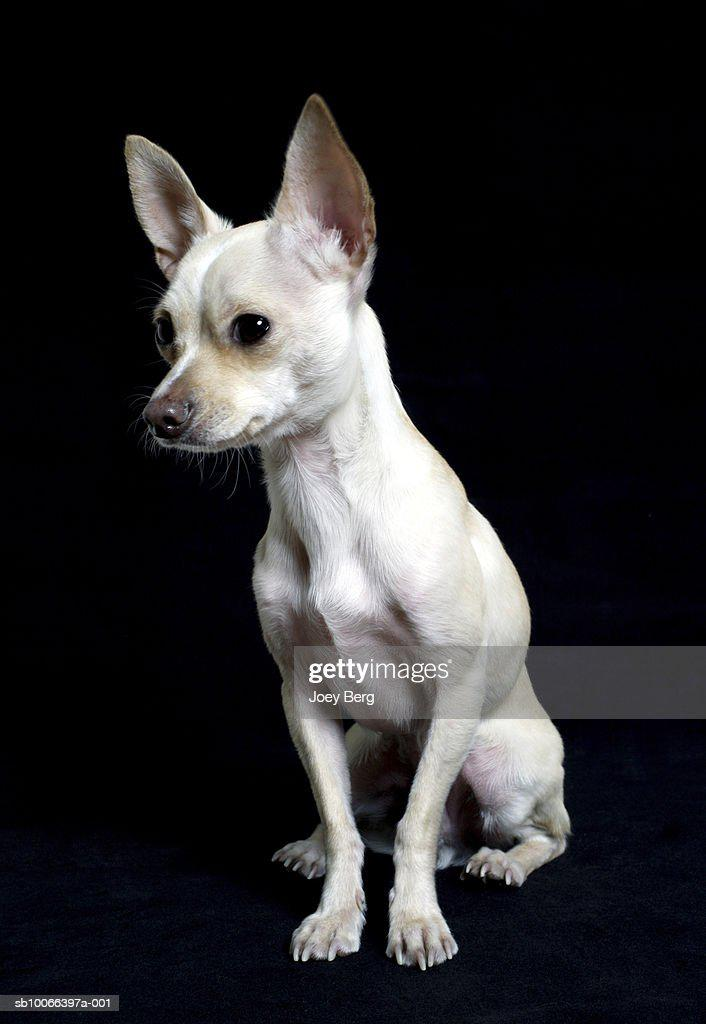

In [7]:
# Setting the seed to allow reproducibility
random.seed(42) 

# Getting a random image path
random_image_path = random.choice(df.filename)

# Opening the image
img = Image.open("dataset/"+random_image_path)

# Printing metadata
print("Random image path: ",random_image_path)
print("\nImage class: ",df[df.filename == random_image_path].label.item())
print("\nImage height: ",img.height) 
print("\nImage width: ",img.width)
img

(-0.5, 705.5, 1023.5, -0.5)

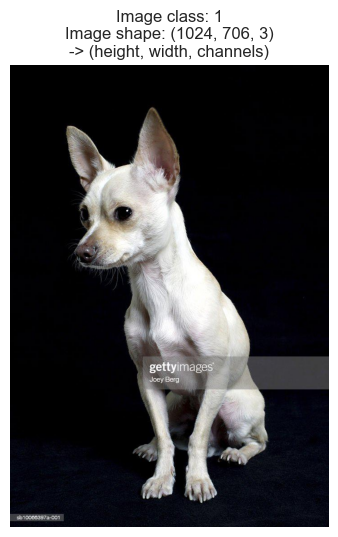

In [8]:
# Turning the image into an array
img_as_array = np.asarray(img)

# Plotting the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
title_str = "Image class: "+str(df[df.filename == random_image_path].label.item())+"\nImage shape: "+str(img_as_array.shape)+"\n-> (height, width, channels)"
plt.title(title_str)
plt.axis(False)

In [9]:
# Finding all the unique shapes of the images inside the dataset
shape_arr = []

for i in range(0,df.shape[0]):
    with Image.open("dataset/"+df.iloc[i].filename) as img:
        width,height = img.size
        shape_arr.append((width,height))

print("The unique shapes of the images in the dataset are: ",np.unique(shape_arr,axis= 0).__len__())
print("The biggest shape is: ",np.max(shape_arr,axis= 0))
print("The smallest shape is: ",np.min(shape_arr, axis= 0))

The unique shapes of the images in the dataset are:  2171
The biggest shape is:  [4603 4096]
The smallest shape is:  [102 129]


In [10]:
# ## The following lines of code take a lot of time; uncomment to test

# # Retrieving the overall mean for subsequent normalization purposes
# r_mean_arr = []
# g_mean_arr = []
# b_mean_arr = []


# for i in tqdm(range(0,df.shape[0])):
#    img_path = "dataset/"+df.iloc[i].filename
#    with Image.open(img_path) as img:
#        img_np = np.array(img.getdata()).reshape(img.size[0],img.size[1],3)
#        r_mean,g_mean,b_mean = np.mean(img_np,axis=(0,1))
#        r_mean_arr.append(r_mean)
#        g_mean_arr.append(g_mean)
#        b_mean_arr.append(b_mean)

# R_MEAN = np.mean(r_mean_arr) / 255
# G_MEAN = np.mean(g_mean_arr) / 255
# B_MEAN = np.mean(b_mean_arr) / 255

# RGB_df = pd.DataFrame(columns= ["R_MEAN","G_MEAN","B_MEAN"])
# RGB_df["R_MEAN"] = [R_MEAN]
# RGB_df["G_MEAN"] = [G_MEAN]
# RGB_df["B_MEAN"] = [B_MEAN]
# RGB_df.to_csv("csv/RGB_df.csv") # save the values in a csv

In [11]:
# ## The following lines of code take a lot of time; uncomment to test
# #
# # Retrieving the overall standard deviation for subsequent normalization purposes
# r_std_arr = []
# g_std_arr = []
# b_std_arr = []

# for i in tqdm(range(0,df.shape[0])):
#    img_path = "dataset/"+df.iloc[i].filename    
#    with Image.open(img_path) as img:
#        img_np = np.array(img.getdata()).reshape(img.size[0],img.size[1],3)
#        r_std,g_std,b_std = np.std(img_np,axis=(0,1))
#        r_std_arr.append(r_std)
#        g_std_arr.append(g_std)
#        b_std_arr.append(b_std)

# R_STD = np.mean(r_std_arr) / 255
# G_STD = np.mean(g_std_arr) / 255
# B_STD = np.mean(b_std_arr) / 255

# RGB_std_df = pd.DataFrame(columns= ["R_STD","G_STD","B_STD"])
# RGB_std_df["R_STD"] = [R_STD]
# RGB_std_df["G_STD"] = [G_STD]
# RGB_std_df["B_STD"] = [B_STD]
# RGB_std_df.to_csv("csv/RGB_std_df.csv") # save the values in a csv

In [12]:
# Recovering the overall mean from csv
RGB_df = pd.read_csv("csv/RGB_df.csv")
print("Red ch mean = ",RGB_df.iloc[0].R_MEAN.item(),"\nGreen ch mean = ",RGB_df.iloc[0].G_MEAN.item(),"\nBlue ch mean = ",RGB_df.iloc[0].B_MEAN.item())

# Recovering the overall standard deviation from csv
RGB_std_df = pd.read_csv("csv/RGB_std_df.csv")
print("\nRed ch std = ",RGB_std_df.iloc[0].R_STD.item(),"\nGreen ch std = ",RGB_std_df.iloc[0].G_STD.item(),"\nBlue ch std = ",RGB_std_df.iloc[0].B_STD.item())

Red ch mean =  0.6498746996155592 
Green ch mean =  0.5931436234290047 
Blue ch mean =  0.5394318654208937

Red ch std =  0.2355511601129523 
Green ch std =  0.2434181301556764 
Blue ch std =  0.2557378521513448


In [13]:
# Defining the transformations on images

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH,IMAGE_HEIGHT)
R_MEAN = RGB_df.iloc[0].R_MEAN.item()
G_MEAN = RGB_df.iloc[0].G_MEAN.item()
B_MEAN = RGB_df.iloc[0].B_MEAN.item()
R_STD = RGB_std_df.iloc[0].R_STD.item()
G_STD = RGB_std_df.iloc[0].G_STD.item()
B_STD = RGB_std_df.iloc[0].B_STD.item()

data_transform = transforms.Compose([
    # Resizing the images to IMAGE_SIZE x IMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Turning the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    # Normalizing to the overall mean and std
    transforms.Normalize(mean=[R_MEAN,G_MEAN,B_MEAN],std=[R_STD,G_STD,B_STD])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

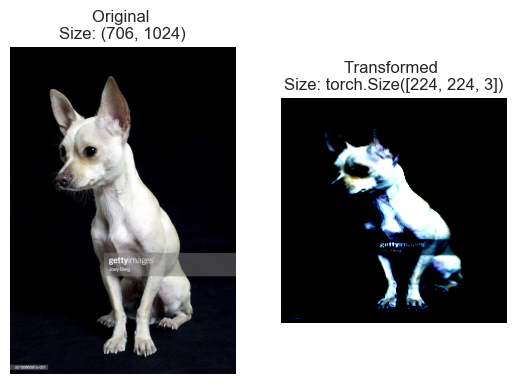

In [14]:
# Effect of transformation on one image of example

# Setting the seed to allow reproducibility
random.seed(42) 

# Getting a random image path
random_image_path = random.choice(df.filename)

# Opening the image
img = Image.open("dataset/"+random_image_path)

# Plotting the original image
fig,ax = plt.subplots(1,2)
ax[0].imshow(img)
title_str = "Original \nSize: "+str(img.size)
ax[0].set_title(title_str)
ax[0].axis("off")

# Transform and plot image
# Note: permute() will change shape of image to suit matplotlib 
# (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
transformed_image = data_transform(img).permute(1, 2, 0) 
ax[1].imshow(transformed_image) 
title_str = "Transformed \nSize: "+str(transformed_image.shape)
ax[1].set_title(title_str)
ax[1].axis("off")

In [15]:
## Keeping the first split of the 5-folds cross-validation
## x and y of the new DataSet correspond to filenames and labels, respectively
train_data = MuffinChihuahuaData(df.iloc[train_idx["train_0"].values]["filename"],df.iloc[train_idx["train_0"].values]["label"],transform=data_transform)
val_data = MuffinChihuahuaData(df.iloc[val_idx["val_0"].values]["filename"],df.iloc[val_idx["val_0"].values]["label"],transform=data_transform)

# Check the lengths
print("The lengths of the training and validation sets: ",len(train_data),len(val_data))

# Turn train and validation Datasets into DataLoaders
trainloader = DataLoader(train_data,batch_size=32)
validationloader = DataLoader(val_data,batch_size=32)

The lengths of the training and validation sets:  4732 1183


In [16]:
# # Visualizing the content of the first training batch
# for i_batch,sample_batched in enumerate(trainloader):
#     if i_batch == 1:
#         break
#     fig,axs = plt.subplots(ncols=8,nrows=4,figsize=(15, 8))
#     axs = axs.flatten()
#     for i in range(len(sample_batched["image"])):
#         axs[i].imshow(sample_batched["image"][i].permute(1,2,0))
#         axs[i].set_title(str(sample_batched["label"][i]))
#         axs[i].axis("off")

In [17]:
# Instantiating the CNN-based image classifier.
model = ImageClassifier().to(device)

In [18]:
# Getting a single image from the batch
for i_batch,sample_batched in enumerate(trainloader):
    if i_batch == 1:
        break
    img_single = sample_batched["image"][0].unsqueeze(dim=0)
    label_single = sample_batched["label"][0]
print("Single image shape: ",img_single.shape,"\n")

# Performing a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# Printing out what's happening and convert model logits -> pred probs -> pred label
print("Output logits:\n",pred,"\n")
print("Output prediction probabilities:\n",torch.softmax(pred, dim=1),"\n")

print("Output prediction label:\n",torch.argmax(torch.softmax(pred, dim=1), dim=1),
      f"--> {'chihuahua' if torch.argmax(torch.softmax(pred, dim=1), dim=1) == 1 else 'muffin'}\n")

print(f"Actual label: {label_single} --> {'chihuahua' if label_single == 1 else 'muffin'}\n")

Single image shape:  torch.Size([1, 3, 224, 224]) 

Output logits:
 tensor([[0.0009, 0.0255]]) 

Output prediction probabilities:
 tensor([[0.4938, 0.5062]]) 

Output prediction label:
 tensor([1]) --> chihuahua

Actual label: 1 --> chihuahua



In [19]:
# Doing a test pass through of an example input size 
summary(model,input_size=[1,3,IMAGE_WIDTH,IMAGE_HEIGHT]) 

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

In [20]:
## These lines take a lot of time; you will load the trained model in the following 
from utils import train

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3) # 10e-2

In [21]:
# ## You can find the model and result corresponding to each fold in the files inside the directory

# # Continue the training and validation of the model for all the other folds
# for i in range(0,5):
#    # Keeping the split
#    train_str = "train_"+str(i)
#    val_str = "val_"+str(i)
#    train_data = MuffinChihuahuaData(df.iloc[train_idx[train_str].values]["filename"],df.iloc[train_idx[train_str].values]["label"],transform=data_transform)
#    val_data = MuffinChihuahuaData(df.iloc[val_idx[val_str].values]["filename"],df.iloc[val_idx[val_str].values]["label"],transform=data_transform)
#    # Turn train and validation Datasets into DataLoaders
#    trainloader = DataLoader(train_data,batch_size=32)
#    validationloader = DataLoader(val_data,batch_size=32)
#    # Start the timer
#    from timeit import default_timer as timer 
#    start_time = timer()
#    # Train model 
#    model_results = train(model=model,
#                          train_dataloader=trainloader,
#                          val_dataloader=validationloader,
#                          optimizer=optimizer,
#                          loss_fn=loss_fn,
#                          epochs=NUM_EPOCHS,
#                          split=i)
#    # End the timer and print out how long it took
#    end_time = timer()
#    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
#    # Extract train and validation loss and accuracy at each epoch 
#    results = dict(list(model_results.items()))
#    # Get the loss values of the results dictionary (training and validation)
#    train_loss = results["train_loss"]
#    val_loss = results["val_loss"]
#    # Get the accuracy values of the results dictionary (training and validation)
#    train_acc = results["train_acc"]
#    val_acc = results["val_acc"]
#    ## Get the f1 scores of the results dictionary
#    val_f1 = results["val_f1"]

#    # Figure out how many epochs there were
#    epochs = range(len(results["train_loss"]))
#    # Save results in a csv
#    results_df = pd.DataFrame(columns= ["train_loss","val_loss","train_acc","val_acc", "val_f1","epochs"])
#    results_df["train_loss"] = train_loss
#    results_df["val_loss"] = val_loss
#    results_df["train_acc"] = train_acc
#    results_df["val_acc"] = val_acc
#    results_df["val_f1"] = val_f1
#    results_df["epochs"] = epochs
#    results_df_name = "results_df_"+str(i)+".csv"
#    results_df.to_csv(results_df_name)

# Loss plot

Max training loss: 0.521
Mean training loss: 0.064
Min training loss: 0.0

Max validation loss: 2.753
Mean validation loss: 0.664
Min validation loss: 0.272



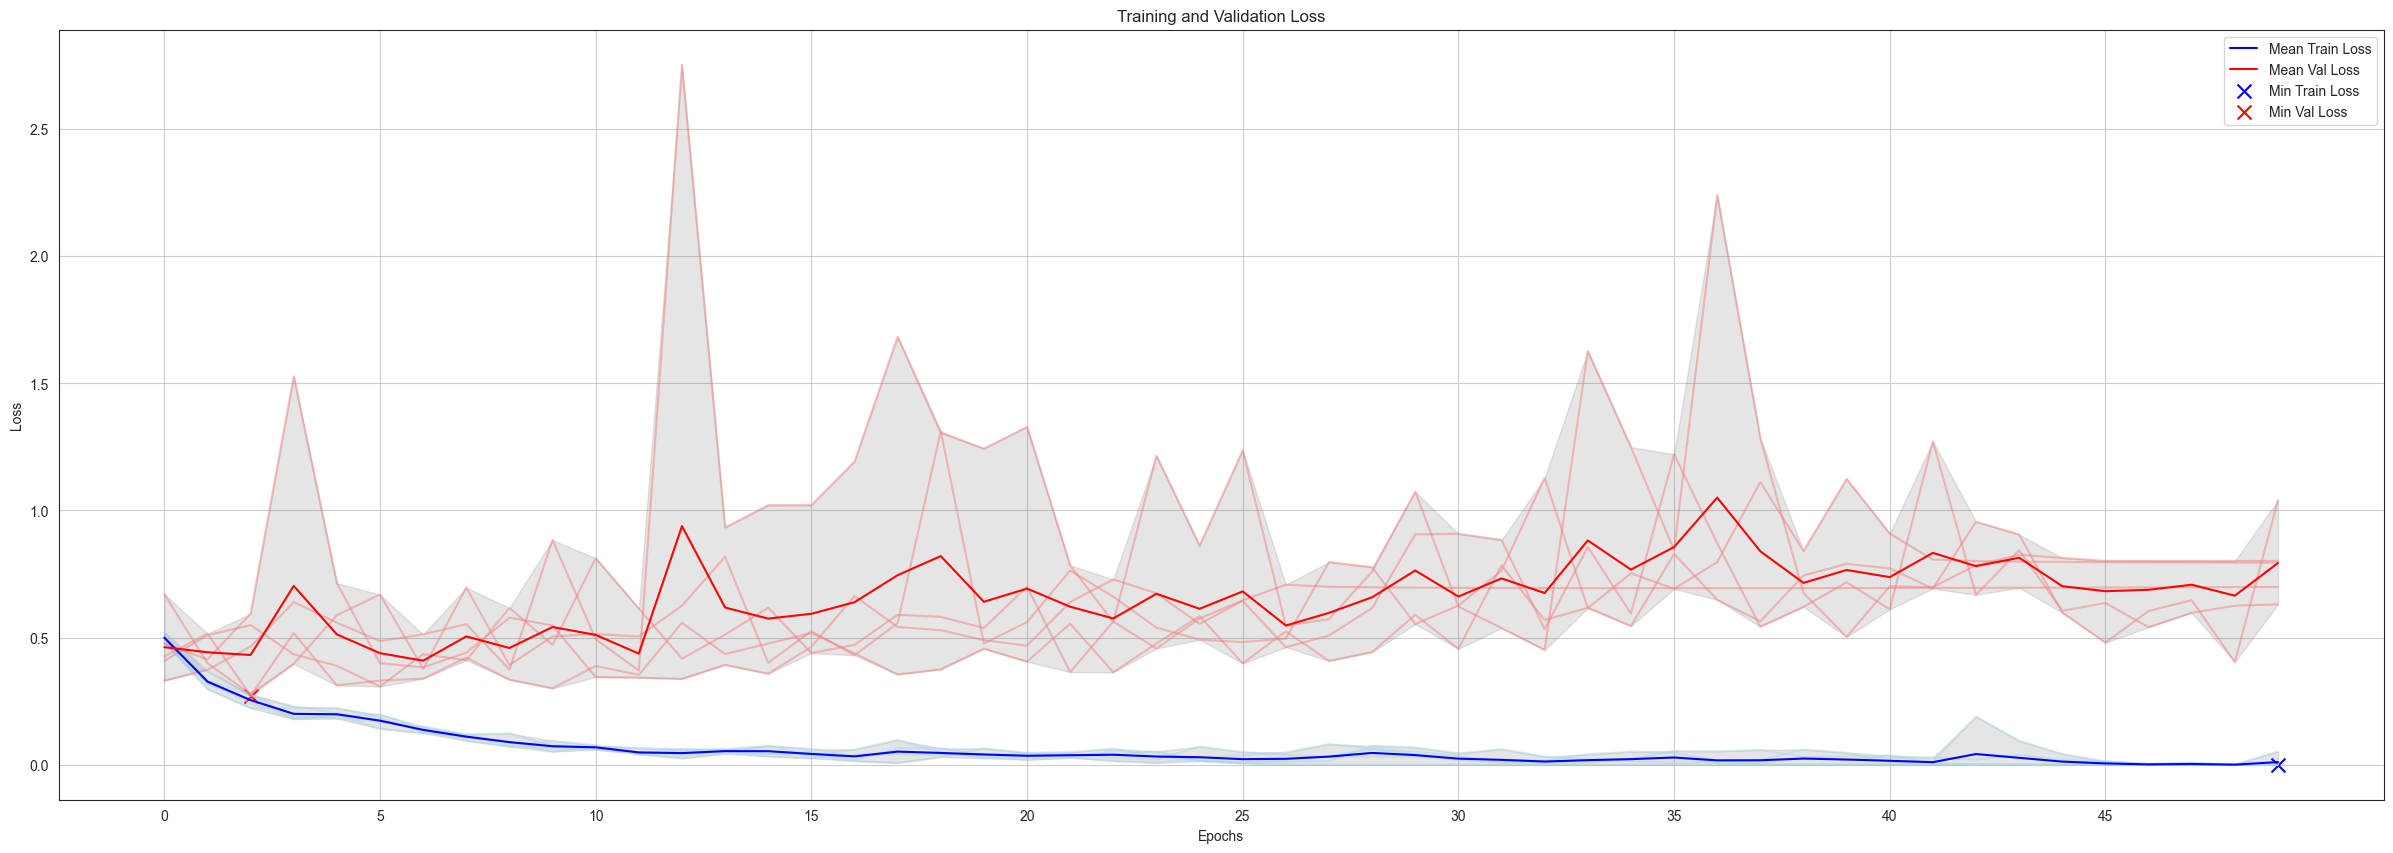

In [22]:
# Read data into a list of DataFrames
num_folds = len(os.listdir("results"))
results = [pd.read_csv(f"results/results_df_{i}.csv") for i in range(num_folds)]

# Combine data from all folds
all_train_loss = np.vstack([result['train_loss'] for result in results])
all_val_loss = np.vstack([result['val_loss'] for result in results])

# Calculate mean losses
mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)

# Print max, mean, and min values for training and validation losses
for name, data in [("Training", all_train_loss), ("Validation", all_val_loss)]:
    print(f"Max {name.lower()} loss: {round(np.max(data), 3)}")
    print(f"Mean {name.lower()} loss: {round(np.mean(data), 3)}")
    print(f"Min {name.lower()} loss: {round(np.min(data), 3)}")
    print()

# Calculate upper and lower boundaries for training and validation losses
max_loss_train = [max(a, b, c, d, e) for a, b, c, d, e in zip(*[result["train_loss"] for result in results])]
min_loss_train = [min(a, b, c, d, e) for a, b, c, d, e in zip(*[result["train_loss"] for result in results])]
max_loss_val = [max(a, b, c, d, e) for a, b, c, d, e in zip(*[result["val_loss"] for result in results])]
min_loss_val = [min(a, b, c, d, e) for a, b, c, d, e in zip(*[result["val_loss"] for result in results])]

# Plot both training and validation losses
plt.figure(figsize=(30, 10))
epochs = range(len(results[0]["epochs"]))

# Plot the range of losses
plt.plot(epochs, all_train_loss.T, color='lightblue', alpha=0.5)
plt.plot(epochs, all_val_loss.T, color='lightcoral', alpha=0.5)

# Plot the mean losses
plt.plot(epochs, mean_train_loss, color='blue', label='Mean Train Loss')
plt.plot(epochs, mean_val_loss, color='red', label='Mean Val Loss')

# Plot the max and min losses
plt.fill_between(epochs, min_loss_train, max_loss_train, color='gray', alpha=0.2)
plt.fill_between(epochs, min_loss_val, max_loss_val, color='gray', alpha=0.2)

# Plot the markers for min losses
for marker_color, data, label in [('blue', min_loss_train, 'Min Train Loss'), ('red', min_loss_val, 'Min Val Loss')]:
    plt.scatter(epochs[data.index(min(data))], min(data), color=marker_color, marker='x', s=100, label=label)

# Add labels and legend
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
# plt.savefig("plots/loss.png")
plt.show()


# Validation plot

Max train accuracy: 1.0
Mean train accuracy: 0.979
Min train accuracy: 0.822

Max validation accuracy: 0.951
Mean validation accuracy: 0.912
Min validation accuracy: 0.731



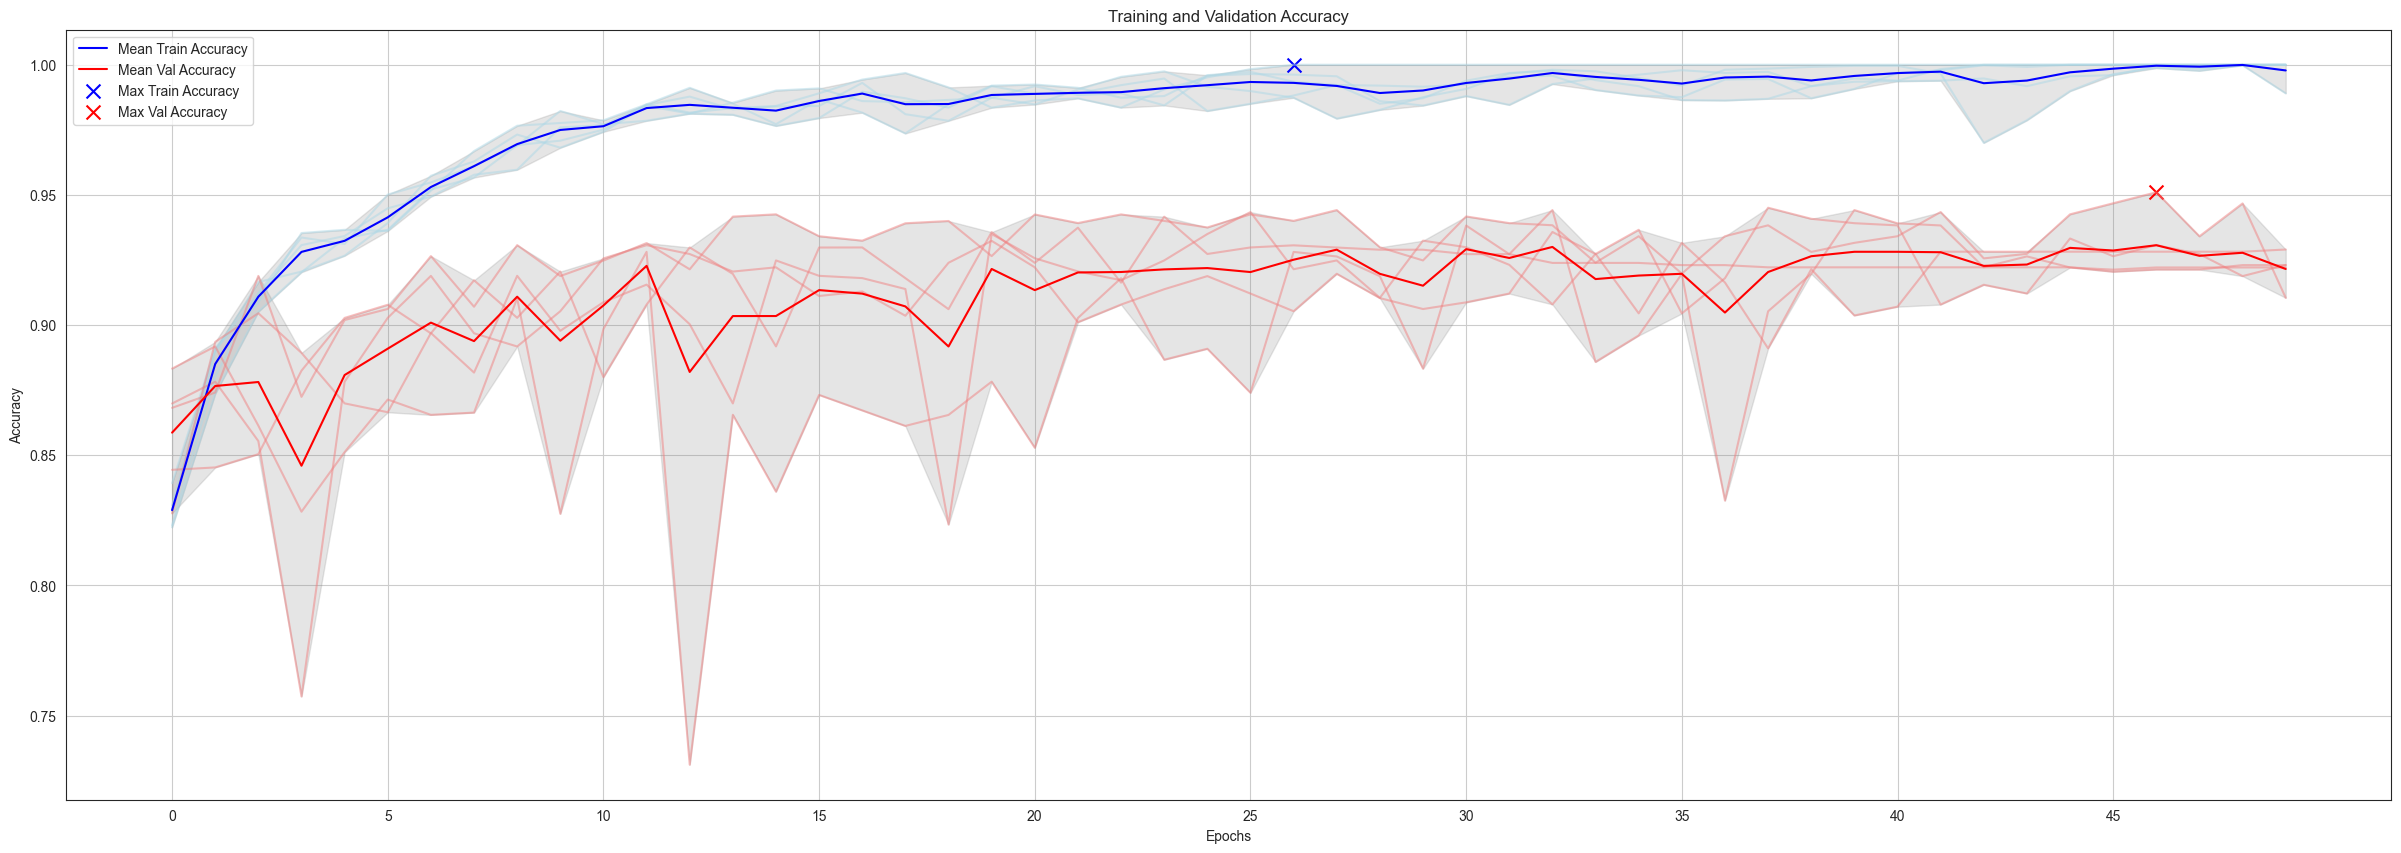

In [23]:
# Combine data from all folds
all_train_acc = np.vstack([result['train_acc'] for result in results])
all_val_acc = np.vstack([result['val_acc'] for result in results])

# Calculate mean accuracies
mean_train_acc = np.mean(all_train_acc, axis=0)
mean_val_acc = np.mean(all_val_acc, axis=0)

# Print max, mean, and min values for training and validation accuracies
for name, data in [("Train", all_train_acc), ("Validation", all_val_acc)]:
    print(f"Max {name.lower()} accuracy: {round(np.max(data), 3)}")
    print(f"Mean {name.lower()} accuracy: {round(np.mean(data), 3)}")
    print(f"Min {name.lower()} accuracy: {round(np.min(data), 3)}")
    print()

# Calculate upper and lower boundaries for training and validation accuracies
max_acc_train = [max(a, b, c, d, e) for a, b, c, d, e in zip(*[result["train_acc"] for result in results])]
min_acc_train = [min(a, b, c, d, e) for a, b, c, d, e in zip(*[result["train_acc"] for result in results])]
max_acc_val = [max(a, b, c, d, e) for a, b, c, d, e in zip(*[result["val_acc"] for result in results])]
min_acc_val = [min(a, b, c, d, e) for a, b, c, d, e in zip(*[result["val_acc"] for result in results])]

# Plot both training and validation accuracies in the same plot
plt.figure(figsize=(30, 10))

# Plot the range of accuracies
plt.plot(epochs, all_train_acc.T, color='lightblue', alpha=0.5)
plt.plot(epochs, all_val_acc.T, color='lightcoral', alpha=0.5)

# Plot the mean accuracies
plt.plot(epochs, mean_train_acc, color='blue', label='Mean Train Accuracy')
plt.plot(epochs, mean_val_acc, color='red', label='Mean Val Accuracy')

# Plot the max and min accuracies
plt.fill_between(epochs, min_acc_train, max_acc_train, color='gray', alpha=0.2)
plt.fill_between(epochs, min_acc_val, max_acc_val, color='gray', alpha=0.2)

# Plot the markers for max accuracies
for marker_color, data, label in [('blue', max_acc_train, 'Max Train Accuracy'), ('red', max_acc_val, 'Max Val Accuracy')]:
    plt.scatter(epochs[data.index(max(data))], max(data), marker='x', color=marker_color, s=100, label=label)

# Add labels and legend
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
# plt.savefig("plots/accuracy.png")
plt.show()


# Inference on best model

In [24]:
## Keeping the best model

## Looking across all the best validation accuracies obtained from the five folds
val_accuracies = np.zeros([5,1])
for i in range(3):
    results_string = "results/results_df_"+str(i)+".csv"
    val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
## Get the fold corresponding to the overall best
index = np.argmax(val_accuracies)
print("The best fold is: ",index)

The best fold is:  1


In [25]:
## Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location=torch.device("cpu")) 
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

model_cp = load_checkpoint(f"checkpoint/checkpoint_{index}.pth")
model_cp.to(device)
print(model_cp)

ImageClassifier(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear

# Testing the model 

In [26]:
image = Image.open('./images_test/chihuahua.jpeg')
image = data_transform(image).unsqueeze(dim=0)
pred = model_cp(image.to(device))

print("Output logits:\n",pred,"\n")
print("Output prediction probabilities:\n",torch.softmax(pred, dim=1),"\n") 
print("Output prediction label:\n",torch.argmax(torch.softmax(pred, dim=1), dim=1),
      f"--> {'chihuahua' if torch.argmax(torch.softmax(pred, dim=1), dim=1) == 1 else 'muffin'}\n")

Output logits:
 tensor([[-22.2684,  20.7077]]) 

Output prediction probabilities:
 tensor([[2.1663e-19, 1.0000e+00]]) 

Output prediction label:
 tensor([1]) --> chihuahua



## F1 SCORE 
# Understanding F1 Score

The F1 score is a metric commonly used in binary classification tasks to evaluate the performance of a model. It combines both precision and recall into a single score, providing a more comprehensive assessment of a classifier's effectiveness.

## Precision and Recall

- **Precision**: Precision measures the accuracy of positive predictions made by the model. It is calculated as the ratio of true positive predictions to the total number of positive predictions (true positives + false positives). Precision helps us understand how well the model performs when it predicts a positive outcome.

  $Precision = \frac{True Positives}{True Positives + False Positives}$

- **Recall (Sensitivity or True Positive Rate)**: Recall measures the ability of the model to capture all the positive instances. It is calculated as the ratio of true positive predictions to the total number of actual positive instances (true positives + false negatives). Recall helps us understand how well the model identifies all the relevant positive cases.

  $Recall = \frac{True Positives}{True Positives + False Negatives}$

## F1 Score Calculation

The F1 score is the harmonic mean of precision and recall. It is particularly useful when the class distribution is imbalanced, as it balances the impact of precision and recall. The formula for calculating the F1 score is as follows:

$F1 Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$

## Interpreting F1 Score

- **High F1 Score**: Indicates a balanced trade-off between precision and recall. The model is performing well in both capturing positive instances and avoiding false positives.

- **Low F1 Score**: Suggests an imbalance between precision and recall. The model may be strong in one aspect (precision or recall) but weak in the other.

In summary, the F1 score provides a comprehensive performance metric for binary classification models, taking into account both false positives and false negatives. It is a valuable tool for assessing the overall effectiveness of a classifier, especially in situations where precision and recall need to be balanced.


In [27]:
fold_0_f1 = pd.read_csv("results/results_df_0.csv")["val_f1"]
fold_1_f1 = pd.read_csv("results/results_df_1.csv")["val_f1"]
fold_2_f1 = pd.read_csv("results/results_df_2.csv")["val_f1"]
fold_3_f1 = pd.read_csv("results/results_df_3.csv")["val_f1"]
fold_4_f1 = pd.read_csv("results/results_df_4.csv")["val_f1"]

print("Max f1 score for fold 0: ", round(np.max(fold_0_f1), 3))
print("Max f1 score for fold 1: ", round(np.max(fold_1_f1), 3))
print("Max f1 score for fold 2: ", round(np.max(fold_2_f1), 3))
print("Max f1 score for fold 3: ", round(np.max(fold_3_f1), 3))
print("Max f1 score for fold 4: ", round(np.max(fold_4_f1), 3))

print("\nMean f1 score for fold 0: ", round(np.mean(fold_0_f1), 3))
print("Mean f1 score for fold 1: ", round(np.mean(fold_1_f1), 3))
print("Mean f1 score for fold 2: ",round(np.mean(fold_2_f1), 3))
print("Mean f1 score for fold 3: ", round(np.mean(fold_3_f1), 3))
print("Mean f1 score for fold 4: ", round(np.mean(fold_4_f1), 3))

print("\nTotal mean f1 score: ", round(np.mean([np.mean(fold_0_f1), np.mean(fold_1_f1), np.mean(fold_2_f1), np.mean(fold_3_f1), np.mean(fold_4_f1)]), 3))

Max f1 score for fold 0:  0.945
Max f1 score for fold 1:  0.951
Max f1 score for fold 2:  0.943
Max f1 score for fold 3:  0.941
Max f1 score for fold 4:  0.944

Mean f1 score for fold 0:  0.911
Mean f1 score for fold 1:  0.928
Mean f1 score for fold 2:  0.911
Mean f1 score for fold 3:  0.915
Mean f1 score for fold 4:  0.892

Total mean f1 score:  0.912


# Integrated gradients

$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m} }^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m} }^\text{1.}\times(x - x'))}^\text{2.} }^\text{3.} }{\partial x_{i} } \times \overbrace{\frac{1}{m} }^\text{4.}$

1) Generate alphas $\alpha$
2) Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$
3) Compute gradients between model F output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i} }$
4) Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$
5) Scale integrated gradients with respect to original image = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are the same units and faithfully represent the pixel importance on the original image.


### Loading images and transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


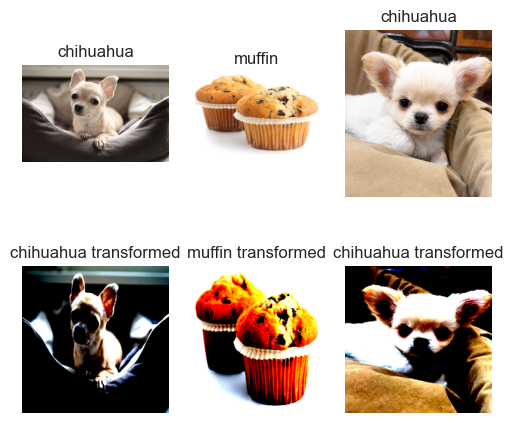

In [28]:
img_chihuahua = Image.open("images_test/chihuahua.jpeg")
img_muffin = Image.open("images_test/muffin.jpeg")
img_chihuahua2 = Image.open("images_test/chihuahua2.jpeg")

img_chihuahua_t = data_transform(img_chihuahua).unsqueeze(dim=0)
img_muffin_t = data_transform(img_muffin).unsqueeze(dim=0)
img_chihuahua_2_t = data_transform(img_chihuahua2).unsqueeze(dim=0)

fig, axs = plt.subplots(2, 3, figsize=(5, 5))

## Plot img_chihuahua
axs[0, 0].imshow(img_chihuahua)
axs[0, 0].set_title('chihuahua')
axs[0, 0].axis('off')

## Plot img_muffin
axs[0, 1].imshow(img_muffin)
axs[0, 1].set_title('muffin')
axs[0, 1].axis('off')

## Plot img_chihuahua_t
axs[1, 0].imshow(img_chihuahua_t.squeeze().permute(1, 2, 0))
axs[1, 0].set_title('chihuahua transformed')
axs[1, 0].axis('off')

## Plot img_muffin_t
axs[1, 1].imshow(img_muffin_t.squeeze().permute(1, 2, 0))
axs[1, 1].set_title('muffin transformed')
axs[1, 1].axis('off')

## plot img_chihuahua_2_t
axs[1, 2].imshow(img_chihuahua_2_t.squeeze().permute(1, 2, 0))
axs[1, 2].set_title('chihuahua transformed')
axs[1, 2].axis('off')

## plot img_chihuahua2
axs[0, 2].imshow(img_chihuahua2)
axs[0, 2].set_title('chihuahua')
axs[0, 2].axis('off')


plt.tight_layout()
plt.savefig("plots/transformations.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


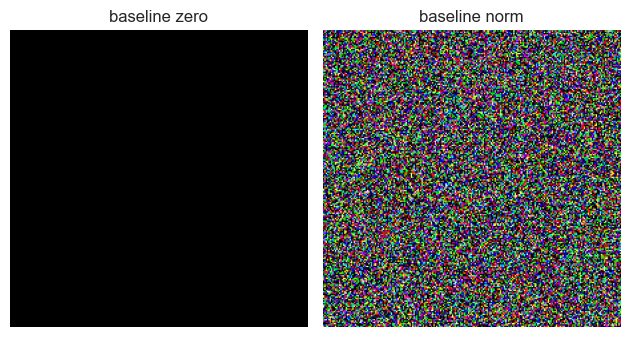

In [29]:
## Baselines 
baseline_zero = torch.zeros(1,3,224,224)
baseline_norm = torch.randn(1,3,224,224)

## Plot baseline_zero
plt.subplot(1, 2, 1)
plt.imshow(baseline_zero.squeeze().permute(1, 2, 0))
plt.title('baseline zero')
plt.axis('off')

## Plot baseline_norm
plt.subplot(1, 2, 2)
plt.imshow(baseline_norm.squeeze().permute(1, 2, 0))
plt.title('baseline norm')
plt.axis('off')

plt.tight_layout()
plt.show()

### Interpolate images

In [40]:
m_steps = 100
alphas = torch.linspace(0, 1, steps=m_steps + 1)

## for chihuahuas zero
interpolated_images_c = interpolate_images(baseline_zero, img_chihuahua_t, alphas)
print("Shape of interpolated images: ",interpolated_images_c.shape)

## for muffins zero
interpolated_images_m = interpolate_images(baseline_zero, img_muffin_t, alphas)
print("Shape of interpolated images: ",interpolated_images_m.shape)

## for chihuahuas norm
interpolated_images_c_norm = interpolate_images(baseline_norm, img_chihuahua_t, alphas)
print("Shape of interpolated images: ",interpolated_images_c_norm.shape)

## for muffins norm
interpolated_images_m_norm = interpolate_images(baseline_norm, img_muffin_t, alphas)
print("Shape of interpolated images: ",interpolated_images_m_norm.shape)

Shape of interpolated images:  torch.Size([1, 51, 3, 224, 224])
Shape of interpolated images:  torch.Size([1, 51, 3, 224, 224])
Shape of interpolated images:  torch.Size([1, 51, 3, 224, 224])
Shape of interpolated images:  torch.Size([1, 51, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


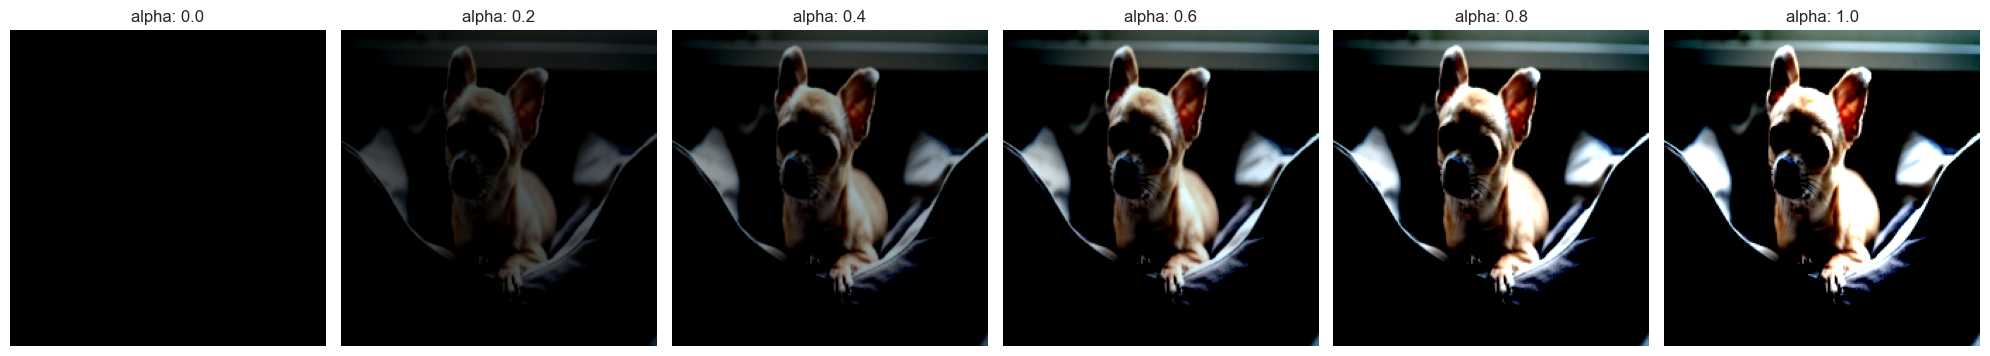

In [41]:
## plot interpolated images chihuahuas zeros
plot_interpolated_images(interpolated_images_c, m_steps, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


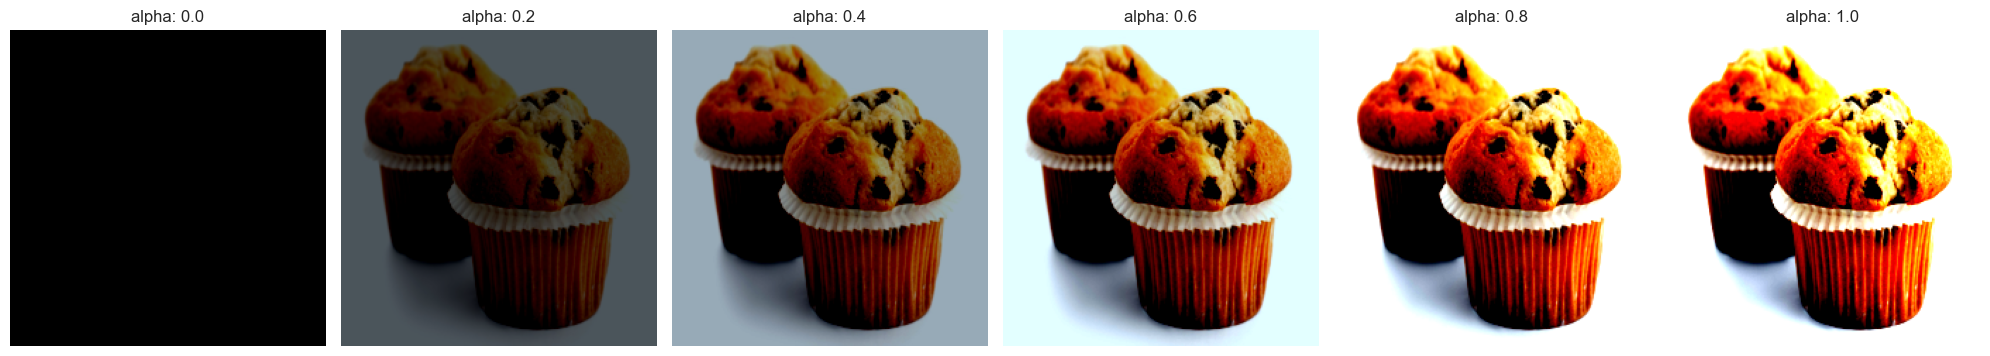

In [42]:
## plot interpolated images muffins zeros
plot_interpolated_images(interpolated_images_m, m_steps, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


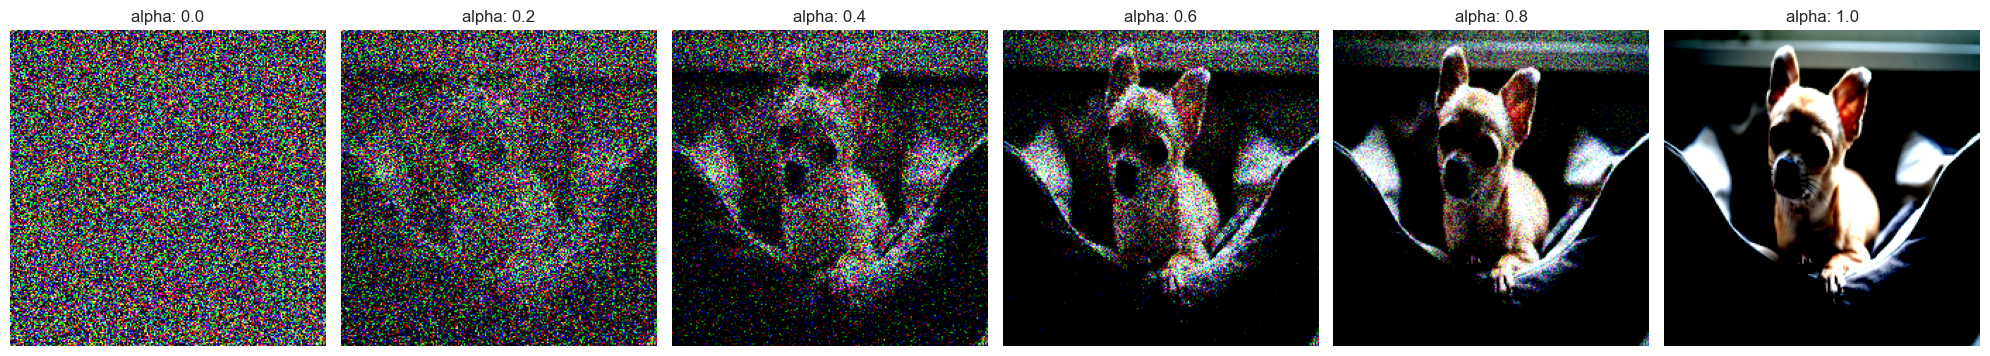

In [43]:
# plot interpolated images chihuahuas norm
plot_interpolated_images(interpolated_images_c_norm, m_steps, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


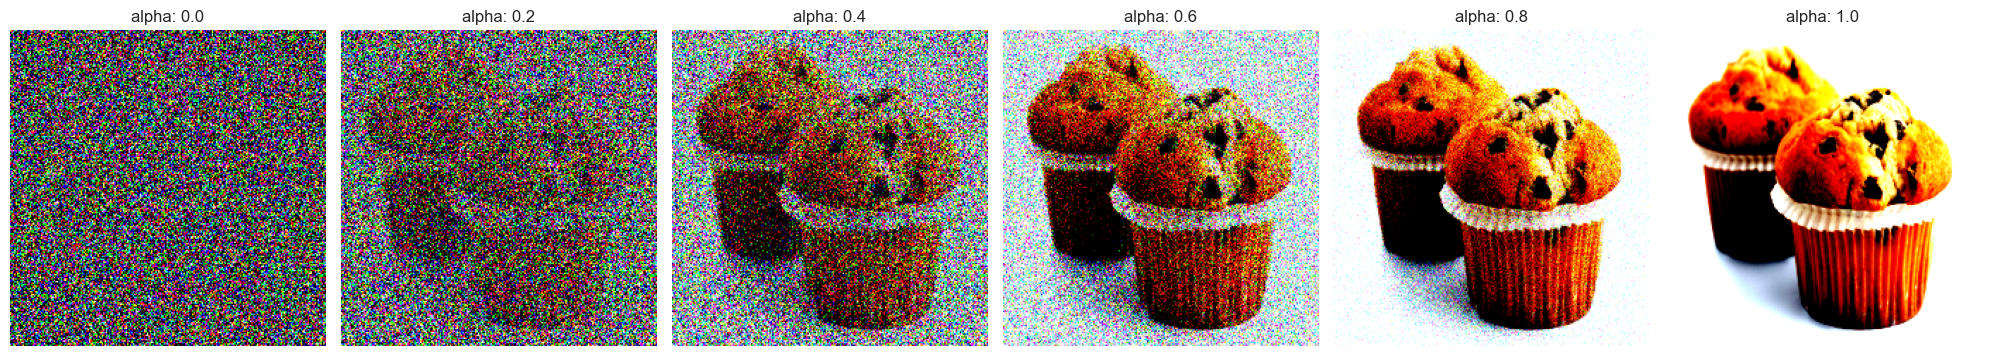

In [44]:
# plot interpolated images muffins norm
plot_interpolated_images(interpolated_images_m_norm, m_steps, 10)

### Compute gradients with our method

In [62]:
## Integrated gradients for chihuahua with baseline_zero
ig_c = integrated_gradients(baseline=baseline_zero,
                            image=img_chihuahua_t,
                            target_class_idx=1,
                            model=model_cp,
                            m_steps=m_steps, 
                            batch_size=1)

ig_c = torch.sum(torch.abs(ig_c), dim=1)
# ig_c = ig_c - ig_c.min() / (ig_c.max() - ig_c.min())
ig_c = np.transpose(ig_c.detach().numpy(), (1, 2, 0))
ig_c_zero_baseline = ig_c

100%|██████████| 51/51 [00:05<00:00,  9.74it/s]


### Integrated gradients with captum

In [63]:
## Integrated gradients for chihuaha with baseline_zero captum
from captum.attr import IntegratedGradients

integrated_grads = IntegratedGradients(model_cp)
ig_c_captum = integrated_grads.attribute(img_chihuahua_t, target=1, baselines=baseline_zero, n_steps=m_steps)

ig_c_captum = torch.sum(torch.abs(ig_c_captum), dim=1)
ig_c_captum = np.transpose(ig_c_captum.detach().numpy(), (1, 2, 0)).squeeze()
ig_c_zero_baseline_captum = ig_c_captum

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


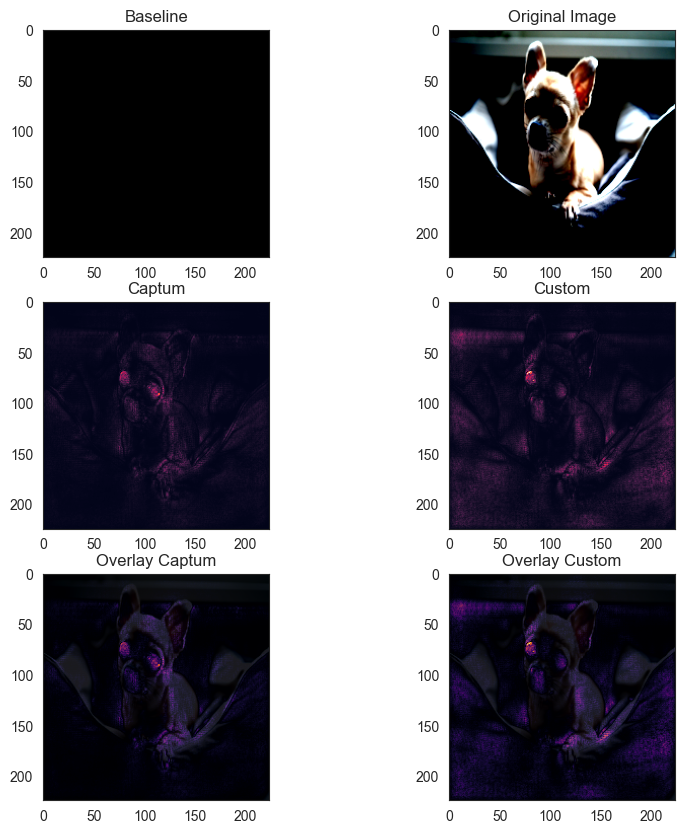

In [64]:
plot_image(img_chihuahua_t, ig_c_captum, ig_c, baseline_zero)

In [59]:
# Integrated gradients for chihuahua with baseline_norm
ig_c = integrated_gradients(baseline=baseline_norm,
                            image=img_chihuahua_t,
                            target_class_idx=1,
                            model=model_cp,
                            m_steps=m_steps, 
                            batch_size=1)

ig_c = torch.sum(torch.abs(ig_c), dim=1)
ig_c = np.transpose(ig_c.detach().numpy(), (1, 2, 0))
ig_c_norm_baseline = ig_c

100%|██████████| 51/51 [00:05<00:00, 10.02it/s]


In [60]:
## Integrated gradients for chihuaha with baseline_norm captum
from captum.attr import IntegratedGradients

integrated_grads = IntegratedGradients(model_cp)
ig_c_captum = integrated_grads.attribute(img_chihuahua_t, target=1, baselines=baseline_norm, n_steps=m_steps)

ig_c_captum = torch.sum(torch.abs(ig_c_captum), dim=1)
ig_c_captum = np.transpose(ig_c_captum.detach().numpy(), (1, 2, 0)).squeeze()
ig_c_norm_baseline_captum = ig_c_captum

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


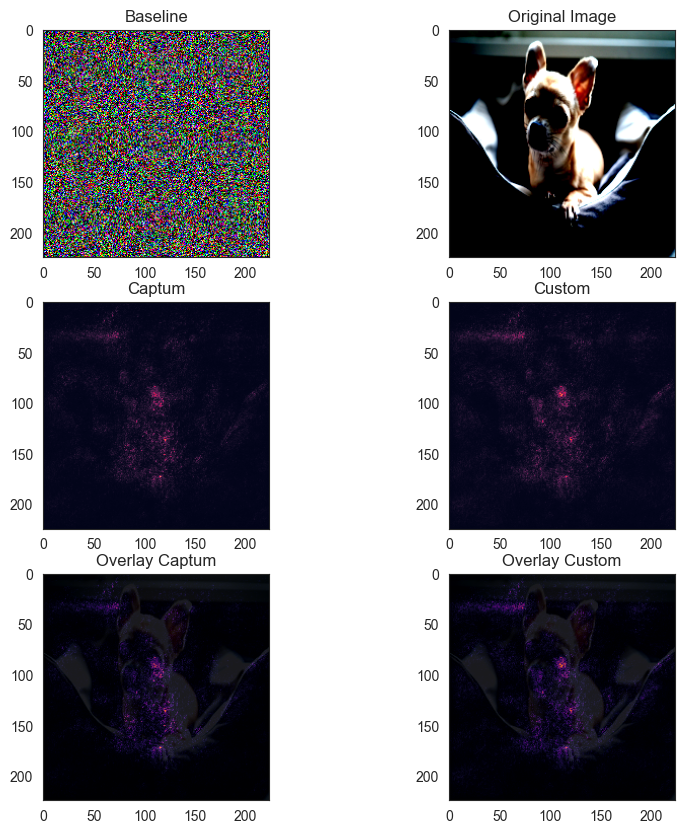

In [61]:
plot_image(img_chihuahua_t, ig_c_captum, ig_c, baseline_norm)

In [ ]:
## Integrated gradients for muffin with baseline_zero
ig_m = integrated_gradients(baseline=baseline_zero,
                            image=img_muffin_t,
                            target_class_idx=0,
                            model=model_cp,
                            m_steps=m_steps, 
                            batch_size=1)

ig_m = torch.sum(torch.abs(ig_m), dim=1)
ig_m = np.transpose(ig_m.detach().numpy(), (1, 2, 0))
ig_m_zero_baseline = ig_m

In [ ]:
## Integrated gradients for muffin with baseline_zero captum
from captum.attr import IntegratedGradients

integrated_grads = IntegratedGradients(model_cp)
ig_m_captum = integrated_grads.attribute(img_muffin_t, target=0, baselines=baseline_zero, n_steps=m_steps)

ig_m_captum  = torch.sum(torch.abs(ig_m_captum), dim=1)
ig_m_captum = np.transpose(ig_m_captum.detach().numpy(), (1, 2, 0)).squeeze()
ig_m_zero_baseline_captum = ig_m_captum

In [ ]:
plot_image(img_muffin_t, ig_m_captum, ig_m, baseline_zero)

In [ ]:
## Integrated gradients for muffin with baseline_norm
ig_m = integrated_gradients(baseline=baseline_norm,
                            image=img_muffin_t,
                            target_class_idx=0,
                            model=model_cp,
                            m_steps=m_steps, 
                            batch_size=1)

ig_m = torch.sum(torch.abs(ig_m), dim=1)
ig_m = np.transpose(ig_m.detach().numpy(), (1, 2, 0))
ig_m_norm_baseline = ig_m

In [ ]:
## Integrated gradients for muffin with baseline_norm captum
from captum.attr import IntegratedGradients

integrated_grads = IntegratedGradients(model_cp)
ig_m_captum = integrated_grads.attribute(img_muffin_t, target=0, baselines=baseline_norm, n_steps=m_steps)

ig_m_captum = torch.sum(torch.abs(ig_m_captum), dim=1)
ig_m_captum = np.transpose(ig_m_captum.detach().numpy(), (1, 2, 0)).squeeze()
ig_m_norm_baseline_captum = ig_m_captum

In [ ]:
plot_image(img_muffin_t, ig_m_captum, ig_m, baseline_norm)

# Adversarial experiment for finding a baseline

In [ ]:
classifier = model_cp
classifier.to(device)
classifier.eval()
random.seed(16)

def generate_adversarial_example(model, max_iter=100):
    # image = torch.randn((1, 3, 224, 224), requires_grad=True)
    # select a random image from the dataset
    image_path = random.choice(df.filename)
    image = Image.open("dataset/"+image_path)
    image = data_transform(image).unsqueeze(0)
    image.requires_grad = True
    

    target_probability = 0.5
    target_tensor = torch.tensor([target_probability, 1 - target_probability]).to(device)

    optimizer = torch.optim.Adam([image], lr=0.01)

    for _ in tqdm(range(max_iter)):
        output = model(image.to(device))
        loss = F.binary_cross_entropy_with_logits(output, target_tensor.unsqueeze(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        image.data = torch.clamp(image.detach(), 0, 1)
    

    adversarial_example = image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
    return adversarial_example, image

adversarial_example, adversarial_baseline = generate_adversarial_example(classifier)

with torch.no_grad():
    classifier.eval()
    prediction = classifier(torch.tensor(adversarial_example).permute(2, 0, 1).unsqueeze(0).to(device))
    prediction = torch.softmax(prediction, dim=1)
    print("Predictions --> ", prediction, adversarial_example.shape)

## Plot baseline_zero
plt.subplot(1, 3, 1)
plt.imshow(baseline_zero.squeeze().permute(1, 2, 0))
plt.title('baseline zero')
plt.axis('off')

## Plot baseline_norm
plt.subplot(1, 3, 2)
plt.imshow(baseline_norm.squeeze().permute(1, 2, 0))
plt.title('baseline norm')
plt.axis('off')

## plot adversarial example
plt.subplot(1, 3, 3)
plt.imshow(adversarial_example)
plt.title('adversarial example')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
## convert the baseline adversarial example from (224, 224, 3) to (1, 3, 224, 224)
print(adversarial_baseline.shape)

## interpolate images between baseline adversarial example and chihuahua
interpolated_images_c = interpolate_images(adversarial_baseline.detach(), img_chihuahua_t, alphas)

## interpolate images between baseline adversarial example and muffin
interpolated_images_m = interpolate_images(adversarial_baseline.detach(), img_muffin_t, alphas)

In [ ]:
# plot interpolated images chihuahuas adversarial
plot_interpolated_images(interpolated_images_c, m_steps, 10)

In [ ]:
# plot interpolated images muffins adversarial
plot_interpolated_images(interpolated_images_m, m_steps, 10)

In [ ]:
# integrated gradients for chihuahua with baseline adversarial example
ig_c = integrated_gradients(baseline=adversarial_baseline,
                            image=img_chihuahua_t,
                            target_class_idx=1,
                            model=model_cp,
                            m_steps=m_steps, 
                            batch_size=1)

ig_c = torch.sum(torch.abs(ig_c), dim=1)
ig_c = np.transpose(ig_c.detach().numpy(), (1, 2, 0))
ig_c_adversarial = ig_c

In [ ]:
# integrated gradients for chihuahua with baseline adversarial example captum
from captum.attr import IntegratedGradients

integrated_grads = IntegratedGradients(model_cp)
ig_c_captum = integrated_grads.attribute(img_chihuahua_t, target=1, baselines=adversarial_baseline, n_steps=m_steps)

ig_c_captum = torch.sum(torch.abs(ig_c_captum), dim=1)
ig_c_captum = np.transpose(ig_c_captum.detach().numpy(), (1, 2, 0)).squeeze()
ig_c_adversarial_captum = ig_c_captum

In [ ]:
# integrated gradients for muffin with baseline adversarial example
ig_m = integrated_gradients(baseline=adversarial_baseline,
                            image=img_muffin_t,
                            target_class_idx=0,
                            model=model_cp,
                            m_steps=m_steps, 
                            batch_size=1)

ig_m = torch.sum(torch.abs(ig_m), dim=1)
ig_m = np.transpose(ig_m.detach().numpy(), (1, 2, 0))
ig_m_adversarial = ig_m

In [ ]:
# integrated gradients for muffin with baseline adversarial example captum
from captum.attr import IntegratedGradients

integrated_grads = IntegratedGradients(model_cp)
ig_m_captum = integrated_grads.attribute(img_muffin_t, target=0, baselines=adversarial_baseline, n_steps=m_steps)

ig_m_captum = torch.sum(torch.abs(ig_m_captum), dim=1)
ig_m_captum = np.transpose(ig_m_captum.detach().numpy(), (1, 2, 0)).squeeze()
ig_m_adversarial_captum = ig_m_captum

In [ ]:
plot_image(img_chihuahua_t, ig_c_captum, ig_c, adversarial_baseline.detach())

In [ ]:
plot_image(img_muffin_t, ig_m_adversarial, ig_m_adversarial_captum, adversarial_baseline.detach())

# LIME (Local Interpretable Model-agnostic Explanations) to inspect Image classification

In [ ]:
from lime import lime_image
model_cp = load_checkpoint(f"checkpoint/checkpoint_{index}.pth")

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

chihuahua = get_image('./images_test/chihuahua.jpeg')
muffin = get_image('./images_test/muffin.jpeg')

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(chihuahua.resize((224, 224)))
axs[0].axis('off')
axs[0].set_title('chihuahua')

axs[1].imshow(muffin.resize((224, 224)))
axs[1].axis('off')
axs[1].set_title('muffin')

In [ ]:
def get_input_tensors(img):
    return data_transform(img).unsqueeze(0)

print(get_input_tensors(chihuahua).shape)
print(get_input_tensors(muffin).shape)

In [ ]:
index_label = {0: "muffin", 1: 'chihuahua'}

chihuahua_t = get_input_tensors(chihuahua).to(device)
muffin_t = get_input_tensors(muffin).to(device)

model_cp.eval()
model_cp.to(device)

logits_chihuahua = model_cp(chihuahua_t)
logits_muffin = model_cp(muffin_t)

print(logits_chihuahua.shape, logits_muffin.shape)

In [ ]:
probs_chihuahua = F.softmax(logits_chihuahua, dim=1)
probs_muffin = F.softmax(logits_muffin, dim=1)

probs2_chihuahua = probs_chihuahua.topk(2)
probs2_muffin = probs_muffin.topk(2)

In [ ]:
print(tuple((p, c, index_label[c]) for p, c in zip(probs2_chihuahua[0][0].detach().cpu().numpy(), probs2_chihuahua[1][0].detach().cpu().numpy())))
print(tuple((p, c, index_label[c]) for p, c in zip(probs2_muffin[0][0].detach().cpu().numpy(), probs2_muffin[1][0].detach().cpu().numpy())))

In [ ]:
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224)
    ])
    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[R_MEAN, G_MEAN, B_MEAN],
                                     std=[R_STD, G_STD, B_MEAN])

    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    return transf

pil_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    model_cp.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = 'mps'
    model_cp.to(device)
    batch = batch.to(device)

    logits = model_cp(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_chihuahua= batch_predict([pil_transf(chihuahua)])
print(f"Probabilities: --> {test_chihuahua}, Prediction: {test_chihuahua.squeeze().argmax()} --> {index_label[test_chihuahua.squeeze().argmax()]}")
print(test_chihuahua, test_chihuahua.squeeze().argmax())

test_muffin = batch_predict([pil_transf(muffin)])
print(f"\nProbabilities: --> {test_muffin}, Prediction: {test_muffin.squeeze().argmax()} --> {index_label[test_muffin.squeeze().argmax()]}")
print(test_muffin, test_muffin.squeeze().argmax())

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation_chihuahua = explainer.explain_instance(np.array(pil_transf(chihuahua)),
                                            batch_predict,
                                            top_labels=1,
                                            hide_color=0,
                                            num_samples=1000)

explanation_muffin = explainer.explain_instance(np.array(pil_transf(muffin)),
                                            batch_predict,
                                            top_labels=1,
                                            hide_color=0,
                                            num_samples=1000)

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
temp_chi, mask_chi = explanation_chihuahua.get_image_and_mask(explanation_chihuahua.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry_chihuahua1 = mark_boundaries(temp_chi/255.0, mask_chi)


temp_muf, mask_muf = explanation_muffin.get_image_and_mask(explanation_muffin.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry_muffin1 = mark_boundaries(temp_muf/255.0, mask_muf)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle('LIME explanations - positive only', fontsize=16, y=0.75)

axs[0].imshow(img_boundry_chihuahua1)
axs[0].axis('off')
axs[0].set_title('chihuahua')

axs[1].imshow(img_boundry_muffin1)
axs[1].axis('off')
axs[1].set_title('muffin')

In [ ]:

temp_chi2, mask_chi2 = explanation_chihuahua.get_image_and_mask(explanation_chihuahua.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp_chi2/255.0, mask_chi2)

temp_muf2, mask_muf2 = explanation_muffin.get_image_and_mask(explanation_muffin.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2_muffin = mark_boundaries(temp_muf2/255.0, mask_muf2)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
# fig.suptitle('LIME explanations - positive and negative', fontsize=16, y=0.75)

axs[0].imshow(img_boundry2)
axs[0].axis('off')
axs[0].set_title('chihuahua')

axs[1].imshow(img_boundry2_muffin)
axs[1].axis('off')
axs[1].set_title('muffin')

# Getting all together

## Zero baseline chihuahua

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), gridspec_kw = {'wspace':0.1, 'hspace':0.2})

axs[0, 0].imshow(chihuahua.resize((224, 224)))
axs[0, 0].axis('off')
axs[0, 0].set_title('original')

axs[0, 1].imshow(img_boundry_chihuahua1)
axs[0, 1].axis('off')
axs[0, 1].set_title('LIME - positive only')

axs[0, 2].imshow(img_boundry2)
axs[0, 2].axis('off')
axs[0, 2].set_title('LIME - positive and negative')

axs[1, 0].imshow(chihuahua.resize((224, 224)))
axs[1, 0].imshow(ig_c_zero_baseline, alpha=0.9, cmap='inferno')
axs[1, 0].axis('off')
axs[1, 0].set_title('integrated gradients')

axs[1, 1].imshow(chihuahua.resize((224, 224)))
axs[1, 1].imshow(ig_c_zero_baseline_captum, alpha=0.9, cmap='inferno')
axs[1, 1].axis('off')
axs[1, 1].set_title('integrated gradients captum')

axs[1, 2].imshow(baseline_zero.squeeze().permute(1, 2, 0))
axs[1, 2].axis('off')
axs[1, 2].set_title('baseline zero')


## Zero baseline muffin

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), gridspec_kw = {'wspace':0.1, 'hspace':0.2})

axs[0, 0].imshow(muffin.resize((224, 224)))
axs[0, 0].axis('off')
axs[0, 0].set_title('original')

axs[0, 1].imshow(img_boundry_muffin1)
axs[0, 1].axis('off')
axs[0, 1].set_title('LIME - positive only')

axs[0, 2].imshow(img_boundry2_muffin)
axs[0, 2].axis('off')
axs[0, 2].set_title('LIME - positive and negative')

axs[1, 0].imshow(muffin.resize((224, 224)))
axs[1, 0].imshow(ig_m_zero_baseline, alpha=0.9, cmap='inferno')
axs[1, 0].axis('off')
axs[1, 0].set_title('integrated gradients')

axs[1, 1].imshow(muffin.resize((224, 224)))
axs[1, 1].imshow(ig_m_zero_baseline_captum, alpha=0.9, cmap='inferno')
axs[1, 1].axis('off')
axs[1, 1].set_title('integrated gradients captum')

axs[1, 2].imshow(baseline_zero.squeeze().permute(1, 2, 0))
axs[1, 2].axis('off')
axs[1, 2].set_title('baseline zero')

## Normal baseline chihuahua

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), gridspec_kw = {'wspace':0.1, 'hspace':0.2})

axs[0, 0].imshow(chihuahua.resize((224, 224)))
axs[0, 0].axis('off')
axs[0, 0].set_title('original')

axs[0, 1].imshow(img_boundry_chihuahua1)
axs[0, 1].axis('off')
axs[0, 1].set_title('LIME - positive only')

axs[0, 2].imshow(img_boundry2)
axs[0, 2].axis('off')
axs[0, 2].set_title('LIME - positive and negative')

axs[1, 0].imshow(chihuahua.resize((224, 224)))
axs[1, 0].imshow(ig_c_norm_baseline, alpha=0.9, cmap='inferno')
axs[1, 0].axis('off')
axs[1, 0].set_title('integrated gradients')

axs[1, 1].imshow(chihuahua.resize((224, 224)))
axs[1, 1].imshow(ig_c_norm_baseline_captum, alpha=0.9, cmap='inferno')
axs[1, 1].axis('off')
axs[1, 1].set_title('integrated gradients captum')

axs[1, 2].imshow(baseline_norm.squeeze().permute(1, 2, 0))
axs[1, 2].axis('off')
axs[1, 2].set_title('baseline normal')

## Normal baseline muffin

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), gridspec_kw = {'wspace':0.1, 'hspace':0.2})

axs[0, 0].imshow(muffin.resize((224, 224)))
axs[0, 0].axis('off')
axs[0, 0].set_title('original')

axs[0, 1].imshow(img_boundry_muffin1)
axs[0, 1].axis('off')
axs[0, 1].set_title('LIME - positive only')

axs[0, 2].imshow(img_boundry2_muffin)
axs[0, 2].axis('off')
axs[0, 2].set_title('LIME - positive and negative')

axs[1, 0].imshow(muffin.resize((224, 224)))
axs[1, 0].imshow(ig_m_norm_baseline, alpha=0.9, cmap='inferno')
axs[1, 0].axis('off')
axs[1, 0].set_title('integrated gradients')

axs[1, 1].imshow(muffin.resize((224, 224)))
axs[1, 1].imshow(ig_m_norm_baseline_captum, alpha=0.9, cmap='inferno')
axs[1, 1].axis('off')
axs[1, 1].set_title('integrated gradients captum')

axs[1, 2].imshow(baseline_norm.squeeze().permute(1, 2, 0))
axs[1, 2].axis('off')
axs[1, 2].set_title('baseline normal')

## Adversarial baseline chihuahua

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), gridspec_kw = {'wspace':0.1, 'hspace':0.2})

axs[0, 0].imshow(chihuahua.resize((224, 224)))
axs[0, 0].axis('off')
axs[0, 0].set_title('original')

axs[0, 1].imshow(img_boundry_chihuahua1)
axs[0, 1].axis('off')
axs[0, 1].set_title('LIME - positive only')

axs[0, 2].imshow(img_boundry2)
axs[0, 2].axis('off')
axs[0, 2].set_title('LIME - positive and negative')

axs[1, 0].imshow(chihuahua.resize((224, 224)))
axs[1, 0].imshow(ig_c_adversarial, alpha=0.9, cmap='inferno')
axs[1, 0].axis('off')
axs[1, 0].set_title('integrated gradients')

axs[1, 1].imshow(chihuahua.resize((224, 224)))
axs[1, 1].imshow(ig_c_adversarial_captum, alpha=0.9, cmap='inferno')
axs[1, 1].axis('off')
axs[1, 1].set_title('integrated gradients captum')

axs[1, 2].imshow(adversarial_baseline.detach().squeeze().permute(1, 2, 0))
axs[1, 2].axis('off')
axs[1, 2].set_title('adversarial baseline')

## Adversarial baseline muffin

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8, 5), gridspec_kw = {'wspace':0.1, 'hspace':0.2})

axs[0, 0].imshow(muffin.resize((224, 224)))
axs[0, 0].axis('off')
axs[0, 0].set_title('original')

axs[0, 1].imshow(img_boundry_muffin1)
axs[0, 1].axis('off')
axs[0, 1].set_title('LIME - positive only')

axs[0, 2].imshow(img_boundry2_muffin)
axs[0, 2].axis('off')
axs[0, 2].set_title('LIME - positive and negative')

axs[1, 0].imshow(muffin.resize((224, 224)))
axs[1, 0].imshow(ig_m_adversarial, alpha=0.9, cmap='inferno')
axs[1, 0].axis('off')
axs[1, 0].set_title('integrated gradients')

axs[1, 1].imshow(muffin.resize((224, 224)))
axs[1, 1].imshow(ig_m_adversarial, alpha=0.9, cmap='inferno')
axs[1, 1].axis('off')
axs[1, 1].set_title('integrated gradients captum')

axs[1, 2].imshow(adversarial_baseline.detach().squeeze().permute(1, 2, 0))
axs[1, 2].axis('off')
axs[1, 2].set_title('baseline adversarial')

# Comparing XAI methods

## Interpretation of the plots (Histograms)
- DISTRIBUTION SHAPE: The shape of each histogram indicates how the attribution values are distributed. A bell shaped curve might suggest a Gaussian-like distribution, while other shapes could indicate different types of distributions.
- CENTRAL TENDENCY AND SPREAD: The central peak or spread values in the histogram provides insight into the central tendency and variability of the attribution values. A broader spread indicates more variability, while a sharper peak suggests concentrated values around a particular range.
- OUTLIERS AND EXTREMES: Outlying values, if present in the tails of the distribution, might indicate exceptional cases where the attribution values significantly differ from the rest.

# Zero baseline

In [ ]:
## One-dimensional histogram of the attribution maps 

## Chihuahua

fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axs[0].hist(ig_c_zero_baseline.flatten(), bins=20)
axs[0].set_title('integrated gradients')
axs[0].set_xlabel('attribution')


axs[1].hist(ig_c_zero_baseline_captum.flatten(), bins=20)
axs[1].set_title('integrated gradients captum')
axs[1].set_xlabel('attribution')

axs[2].hist(mask_chi2.flatten(), bins=20)
axs[2].set_title('LIME')
axs[2].set_xlabel('attribution')

In [ ]:
## Muffin

fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axs[0].hist(ig_m_zero_baseline.flatten(), bins=20)
axs[0].set_title('integrated gradients')
axs[0].set_xlabel('attribution')

axs[1].hist(ig_m_zero_baseline_captum.flatten(), bins=20)
axs[1].set_title('integrated gradients captum')
axs[1].set_xlabel('attribution')

axs[2].hist(mask_muf2.flatten(), bins=20)
axs[2].set_title('LIME')
axs[2].set_xlabel('attribution')

## Normal baseline

In [ ]:
# One-dimensional histogram of the attribution maps 

## Chihuahua

fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axs[0].hist(ig_c_norm_baseline.flatten(), bins=20)
axs[0].set_title('integrated gradients')
axs[0].set_xlabel('attribution')


axs[1].hist(ig_c_norm_baseline_captum.flatten(), bins=20)
axs[1].set_title('integrated gradients captum')
axs[1].set_xlabel('attribution')

axs[2].hist(mask_chi2.flatten(), bins=20)
axs[2].set_title('LIME')
axs[2].set_xlabel('attribution')

In [ ]:
## Muffin

fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axs[0].hist(ig_m_norm_baseline.flatten(), bins=20)
axs[0].set_title('integrated gradients')
axs[0].set_xlabel('attribution')

axs[1].hist(ig_m_norm_baseline_captum.flatten(), bins=20)
axs[1].set_title('integrated gradients captum')
axs[1].set_xlabel('attribution')

axs[2].hist(mask_muf2.flatten(), bins=20)
axs[2].set_title('LIME')
axs[2].set_xlabel('attribution')

## Adversarial baseline

In [ ]:
# One-dimensional histogram of the attribution maps 

## Chihuahua

fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axs[0].hist(ig_c_adversarial.flatten(), bins=20)
axs[0].set_title('integrated gradients')
axs[0].set_xlabel('attribution')


axs[1].hist(ig_c_adversarial_captum.flatten(), bins=20)
axs[1].set_title('integrated gradients captum')
axs[1].set_xlabel('attribution')

axs[2].hist(mask_chi2.flatten(), bins=20)
axs[2].set_title('LIME')
axs[2].set_xlabel('attribution')

In [ ]:
## Muffin

fig, axs = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axs[0].hist(ig_m_adversarial.flatten(), bins=20)
axs[0].set_title('integrated gradients')
axs[0].set_xlabel('attribution')

axs[1].hist(ig_m_adversarial_captum.flatten(), bins=20)
axs[1].set_title('integrated gradients captum')
axs[1].set_xlabel('attribution')

axs[2].hist(mask_muf2.flatten(), bins=20)
axs[2].set_title('LIME')
axs[2].set_xlabel('attribution')

## Interpretation of the plots (Correlation)
- CORRELATION: If the points on the scatter plot tend to fall along a straight line, it indicates a linear relationship between the two methods. A positive slope implies that as one method assigns higher attribution values, the other method also tends to assign higher values. A negative slope indicates the opposite.
- SPREAD OF POINTS: The concentration and spread of points around the line (if present) indicates how consistent or varied the attribution values are between the two methods. A tighter cluster suggests a higher agreement of consistency between the methods, whereas a scattered distribution indicates discrepancy or differences in attributions.
- OUTLIERS: Any point that fall far from the main cluster might represent instances where one method's attribution significantly differs from the other. These outliers could indicate areas where one method captures important features that the other might not or areas where the methods might not be performing optimally.
- RELATIONSHIP STRENGHT: The closeness of the points to the main trend line (if visible) helps to understand the strenght of the relationship between two methods. A tight clustering around the line suggests a strong correlation, while a more dispersed arrangement implies a weaker relationship.

## Zero baseline

In [ ]:
## correlations between attribution maps 

## Chihuahua
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0].plot(ig_c_zero_baseline.flatten(), ig_c_zero_baseline_captum.flatten(), '.')
axes[0].set_xlabel('integrated gradients')
axes[0].set_ylabel('captum')
axes[0].set_title('IG vs IG captum')

axes[1].plot(ig_c_zero_baseline.flatten(), mask_chi2.flatten(), '.')
axes[1].set_xlabel('integrated gradients')
axes[1].set_ylabel('lime')

axes[2].plot(ig_c_zero_baseline_captum.flatten(), mask_chi2.flatten(), '.')
axes[2].set_xlabel('captum')
axes[2].set_ylabel('lime')

In [ ]:
## Muffin

fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0].plot(ig_m_zero_baseline.flatten(), ig_m_zero_baseline_captum.flatten(), '.')
axes[0].set_xlabel('integrated gradients')
axes[0].set_ylabel('captum')

axes[1].plot(ig_m_zero_baseline.flatten(), mask_muf2.flatten(), '.')
axes[1].set_xlabel('integrated gradients')
axes[1].set_ylabel('lime')

axes[2].plot(ig_m_zero_baseline_captum.flatten(), mask_muf2.flatten(), '.')
axes[2].set_xlabel('captum')
axes[2].set_ylabel('lime')

# Normal baseline

In [ ]:
## correlations between attribution maps 

## Chihuahua
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0].plot(ig_c_norm_baseline.flatten(), ig_c_norm_baseline_captum.flatten(), '.')
axes[0].set_xlabel('integrated gradients')
axes[0].set_ylabel('captum')
axes[0].set_title('IG vs IG captum')

axes[1].plot(ig_c_norm_baseline.flatten(), mask_chi2.flatten(), '.')
axes[1].set_xlabel('integrated gradients')
axes[1].set_ylabel('lime')

axes[2].plot(ig_c_norm_baseline_captum.flatten(), mask_chi2.flatten(), '.')
axes[2].set_xlabel('captum')
axes[2].set_ylabel('lime')

In [ ]:
## correlations between attribution maps 

## muffin
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0].plot(ig_m_norm_baseline.flatten(), ig_m_norm_baseline_captum.flatten(), '.')
axes[0].set_xlabel('integrated gradients')
axes[0].set_ylabel('captum')
axes[0].set_title('IG vs IG captum')

axes[1].plot(ig_m_norm_baseline.flatten(), mask_chi2.flatten(), '.')
axes[1].set_xlabel('integrated gradients')
axes[1].set_ylabel('lime')

axes[2].plot(ig_m_norm_baseline_captum.flatten(), mask_chi2.flatten(), '.')
axes[2].set_xlabel('captum')
axes[2].set_ylabel('lime')

# Adversarial baseline

In [ ]:
## correlations between attribution maps 

## Chihuahua
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0].plot(ig_c_adversarial.flatten(), ig_c_adversarial_captum.flatten(), '.')
axes[0].set_xlabel('integrated gradients')
axes[0].set_ylabel('captum')
axes[0].set_title('IG vs IG captum')

axes[1].plot(ig_c_adversarial.flatten(), mask_chi2.flatten(), '.')
axes[1].set_xlabel('integrated gradients')
axes[1].set_ylabel('lime')

axes[2].plot(ig_c_adversarial_captum.flatten(), mask_chi2.flatten(), '.')
axes[2].set_xlabel('captum')
axes[2].set_ylabel('lime')

In [ ]:
## correlations between attribution maps 

## Muffin
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw = {'wspace':0.5, 'hspace':0.2})

axes[0].plot(ig_m_adversarial.flatten(), ig_m_adversarial_captum.flatten(), '.')
axes[0].set_xlabel('integrated gradients')
axes[0].set_ylabel('captum')
axes[0].set_title('IG vs IG captum')

axes[1].plot(ig_m_adversarial.flatten(), mask_chi2.flatten(), '.')
axes[1].set_xlabel('integrated gradients')
axes[1].set_ylabel('lime')

axes[2].plot(ig_m_adversarial_captum.flatten(), mask_chi2.flatten(), '.')
axes[2].set_xlabel('captum')
axes[2].set_ylabel('lime')